In [2]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import math

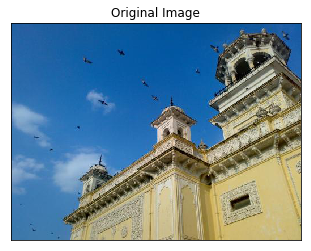

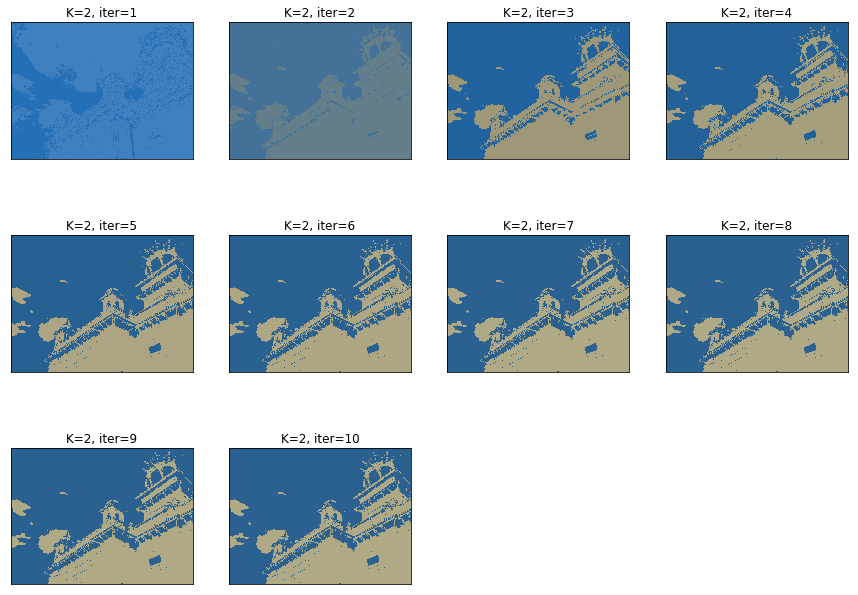

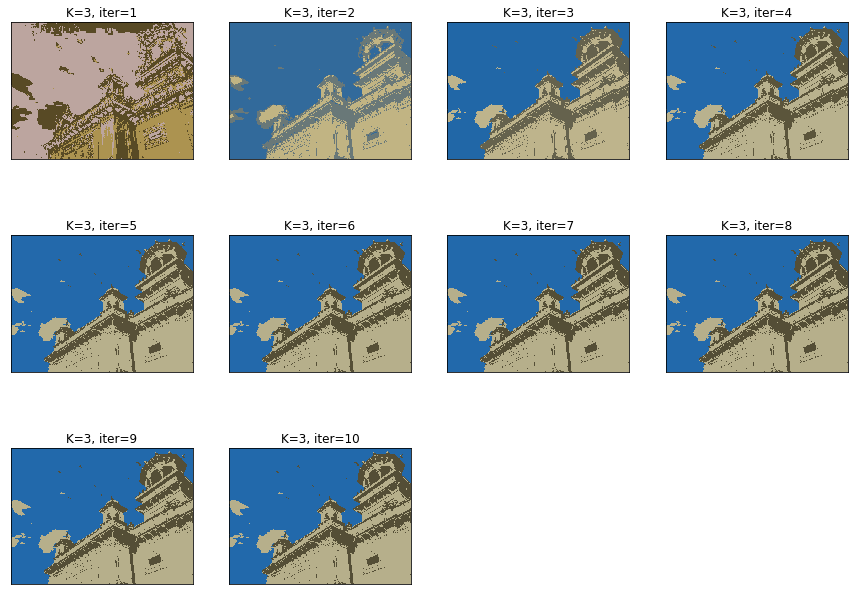

In [178]:
def k_means(img, iterations, k):
    h, w, channels = img.shape
    
    # We assign random points within image as initial means
    means = np.array([img[np.random.randint(0, len(img))]
                    [np.random.randint(0, len(img[0]))] for i in range(k)])
    cluster_list = []
    for i in range(iterations):
        dist = []
        # We find the distance of each pixel to our means
        for m in means:
            dist.append(img - m)
        dist = np.linalg.norm(np.array(dist), axis=-1)
        
        # We see which mean the point is closest to
        clusters = np.argmin(dist, axis = 0)
        
        # We create our output images by seeing which cluster a pixel
        # belongs to and assigning that pixel the mean of that cluster 
        count = 0
        img_copy = np.ndarray.copy(img)
        for l in range(k):
            for j, row in enumerate(img):
                for h, pix in enumerate(row):
                    if clusters[j][h] == l:
                        count += 1
                        img_copy[j][h] = means[l].copy()
        
        
        # We recalcalculate the new means 
        means = np.array([[0, 0, 0] for _ in range(k)])
        for j in range(k):
            means[j][0] = np.mean(img[clusters == j][:,0])
            means[j][1] = np.mean(img[clusters == j][:,1])
            means[j][2] = np.mean(img[clusters == j][:,2])
        
        # We add output images to list to display later
        cluster_list.append(img_copy)

    return cluster_list
    
img = cv2.imread('home.jpg')
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
iter_list_2 = k_means(img, 10, 2)

img = cv2.imread('home.jpg')
iter_list_3 = k_means(img, 10, 3)

# display images
plt.figure()
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
plt.title('Original Image'), plt.xticks([]), plt.yticks([])
plt.show()

plt.figure(figsize=(15, 15))
row = 4
col = 4
for i in range(0, 10):
    plt.subplot(row, col, i+1), plt.imshow(iter_list_2[i])
    plt.title('K=2, iter={}'.format(i + 1)), plt.xticks([]), plt.yticks([])
plt.show()

plt.figure(figsize=(15, 15))
for i in range(0, 10):
    plt.subplot(row, col, i+1), plt.imshow(cv2.cvtColor(iter_list_3[i], cv2.COLOR_BGR2RGB))
    plt.title('K=3, iter={}'.format(i + 1)), plt.xticks([]), plt.yticks([])
plt.show()

Iteration:  0
Iteration:  1
Iteration:  2
Iteration:  3
Iteration:  4
Iteration:  5
Iteration:  6
Iteration:  7
Iteration:  8
Iteration:  9
Iteration:  0
Iteration:  1
Iteration:  2
Iteration:  3
Iteration:  4
Iteration:  5
Iteration:  6
Iteration:  7
Iteration:  8
Iteration:  9


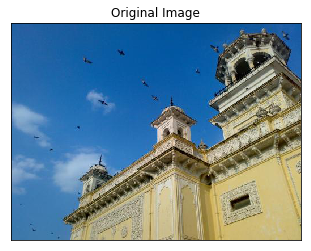

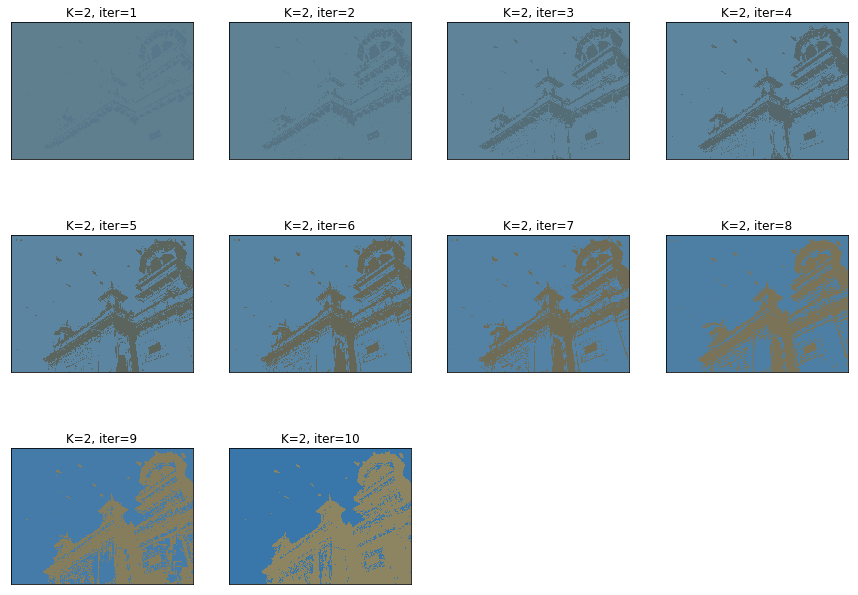

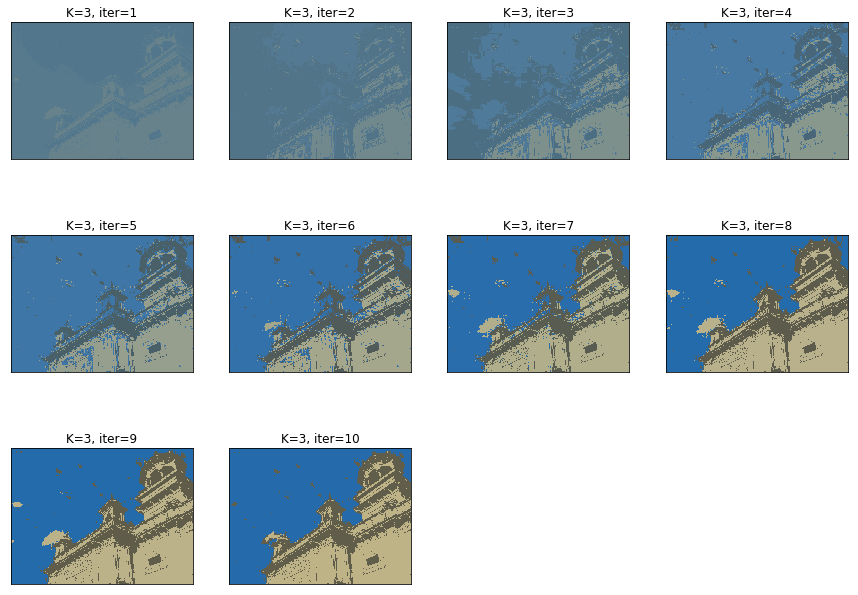

In [215]:
def mv_gauss(pixel, mean, cov):
    # Calculate the PDF of a multivariate gaussian
    # returns probability that a pixel belongs to a certain Multivariate 
    # Gaussian PDF
    diff = pixel - mean
    return ((1/(np.sqrt(2*np.pi)*np.sqrt(np.linalg.det(cov))))*
            np.exp(-0.5*np.dot(np.dot((diff).T, np.linalg.inv(cov)), (diff))))

def em(img, k, iterations):
    img = img.copy()
    
    # We first flatten our image so it is easier to loop through 
    flat_img = np.reshape(img, (-1, img.shape[2])) # (196608, 3)
    
    # We initialize our covariance, means and weights
    output_list = []
    # We ensure cov is nonsingular by using the identity matrix 
    cov = np.array([np.eye(3) for i in range(k)]) # (2, 3, 3)
    weights = np.array([1.0/k for i in range(k)]) # (2, 1)
    means = np.array([img[np.random.randint(0, len(img))]
            [np.random.randint(0, len(img[0]))] for i in range(k)]) # (2, 3)    

    probs = np.zeros((flat_img.shape[0], k))
    for it in range(iterations):
        print("Iteration: ", it)
        # Expectation step
        for i, pixel in enumerate(flat_img):
            for j in range(k):
                # We calculate probability for each point
                # to determine which cluster the belong too
                probs[i][j] = weights[j]*mv_gauss(pixel, means[j], cov[j])
            probs[i] /= sum(probs[i])
            
        # probs = np.loadtxt("probs.txt")
        # np.loadtxt("labels", Labels)
        
        # We generate new means, cov and weights
        means, cov, weights = maximize(flat_img, probs, means, k)
        
        # We take the highest probability of the point belonging to other of 
        # k classes
        # And from this we create output images by assigning the pixels the 
        # values of the most probable mean they belong to
        clusters = np.argmax(probs, axis=1)
        img_copy = np.ndarray.copy(flat_img)
        for l in range(k):
            for j, pix in enumerate(flat_img):
                if clusters[j] == l:
                    img_copy[j] = means[l].copy()
        output_list.append(np.reshape(img_copy, (img.shape)))
    
    return output_list
    
    
        
def maximize(data, probs, means, k):
    # Sum all probabilities along columns
    prob_sum = probs.sum(axis=0) # (k)
    
    # Number of pixels in image
    N = data.shape[0]
    
    # To calculate means we multiply data points by probabilities
    # we then sum across the columns to find overall mean for that cluster
    new_means = np.zeros((k, 3))
    for i in range(k):
        temp = data*np.reshape(probs[:, i], (-1, 1))
        temp = temp.sum(axis=0)
        temp /= prob_sum[i]
        new_means[i] = temp
    
    new_weight = np.zeros(k)
    for i in range(k):
        new_weight[i] = prob_sum[i] /  N       
    
    new_cov = np.zeros((k, 3, 3))
    for i in range(k):
        for j, pixel in enumerate(data):
            diff = (pixel - means[i])[np.newaxis]
            new_cov[i] += probs[j][i] * np.dot(np.transpose(diff), diff)
        new_cov[i] /= prob_sum[i] 

    return new_means, new_cov, new_weight
        
    
    
img = cv2.imread('home.jpg')
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)/255
iterations = 10
iter_list_2 = em(img, 2, iterations)

img = cv2.imread('home.jpg')
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)/255
iter_list_3 = em(img, 3, iterations)


img = cv2.imread('home.jpg')
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)/255
# display images
plt.figure()
plt.imshow(img)
plt.title('Original Image'), plt.xticks([]), plt.yticks([])
plt.show()

plt.figure(figsize=(15, 15))
row = 4
col = 4
for i in range(0, iterations):
    plt.subplot(row, col, i+1), plt.imshow(iter_list_2[i])
    plt.title('K=2, iter={}'.format(i + 1)), plt.xticks([]), plt.yticks([])
plt.show()

plt.figure(figsize=(15, 15))
for i in range(0, iterations):
    plt.subplot(row, col, i+1), plt.imshow(iter_list_3[i])
    plt.title('K=3, iter={}'.format(i + 1)), plt.xticks([]), plt.yticks([])
plt.show()

#### Under what data distribution conditions would K-means and EM give the same solution, provided similar initializations?

K-means and EM would give the same result if the data distribution is spherically distributed. This would mean the mean of the distribution and the expectation of the distrubtion will both be at the same location. This would mean that for k-means, we would have the same clusters produced as if we were to do EM. This would mean that both algorithm would provide the same result. 

In EM, having spherical clusters will ensure covariance matrices that are identical and ensure that the cluster which the data point belongs to only relies on the distance of a point to the mean, almost identically to K-means.

If the two images are in large separated clusters it is beneficial for both algorithms and the larger the separation between each, the more likely they would produce the same result. 